# loading ground truth data from csv file

`load_ground_truth_events` returns a list of `load_data.Event` wich contains metadata about a series of frames that may or may not show trophallaxis.
each `Event` has a property `observations`, which is a list of `load_data.Observation` which contains metadata about one frame.
The csv format is the one used by Andreas Berg, see help output for details.

In [1]:
from bb_txdetect.load_data import load_ground_truth_events
help(load_ground_truth_events)

/usr/lib/python3/dist-packages/matplotlib/__init__.py:874: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/usr/local/lib/python3.5/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


Help on function load_ground_truth_events in module bb_txdetect.load_data:

load_ground_truth_events(csv_path:str, padding:int) -> [<class 'bb_txdetect.load_data.Event'>]
    Return a list of Event objects, one Event per row in the csv file.
    Args:
        csv_path: path to the ground truth data. required columns are:
            track_id_combination, bee_a_detection_ids,bee_b_detection_ids,
            human_decidable_interaction, trophallaxis_observed,
            trophallaxis_start_frame_nr, trophallaxis_end_frame_nr
        padding: set to a positive value to add extra frames at the beginning
            and end of each event.



## saving the images
this will save the images for each event including padding frames before the first and after the last frame. images will be around 600 x 600 to leave room for augmentation.
this may take a very long time. for 2007 events it may take many days

In [2]:
from bb_txdetect.get_images import save_images
help(save_images)

events = [] # use return value of load_ground_truth_events
for i, event in enumerate(events):
    save_images(observations=event.observations, index=i, image_folder="raw_images")

Help on function save_images in module bb_txdetect.get_images:

save_images(observations:[<class 'bb_txdetect.load_data.Observation'>], index:int, image_folder='images_v2_y_events')
    Save an image for each Observation.
    The index is used for naming the folders.



# loading data from individual frames that are not grouped in Events

`load_candidates` calls `save_images` directly

In [3]:
from bb_txdetect.validation import load_candidates
help(load_candidates)

Help on function load_candidates in module bb_txdetect.validation:

load_candidates(frame_padding_length:int=20, json_file_path:str='/mnt/storage/david/cache/beesbook/trophallaxis/candidate_events.json', output_folder:str='/home/mi/mhocke/bb_txdetect_data/images/candidates')
    load images based on json file. the images will need further preprocessing before use.
    json file format:
        [[frame_id, bee_id0, bee_id1, x1, y1, x2, y2, cam_id]]



# preprocessing
after this step, the images are ready for training. this step also takes a long time, but not more than a few hours.

In [4]:
from bb_txdetect.preprocess_images import preprocess_images
help(preprocess_images)

Help on function preprocess_images in module bb_txdetect.preprocess_images:

preprocess_images(image_folder:str, padding:int=16)
    crop and rotate all images and save the processed images
    in two folders with the name {image_folder}_pad{padding}[_invert]
    Args:
        image_folder: input image path
        padding: padding that is left around the image on each side.
                 so e.g. 128x128 with padding 16 leads to 160x160



# training


In [5]:
from bb_txdetect.train import train
help(train)

Help on function train in module bb_txdetect.train:

train(seed, rca, item_depth, drop_frames_around_trophallaxis:bool, auto_archive=True, clahe=False, random_rotation_max=0, model_parameters=None, num_epochs=50, batch_size=64, network=None, save_last_model=False)
    train a network, save stats, maybe save the model.
    Args:
        seed: determines which events go to test and which to train,
                for cross validaiton.
        rca: random crop amplitude, amount of random crops, set to 0 to disable
        item_depth: how many images should the network see for each frame.
                if set to 3 the net sees the center frame and one frame
                before and after.
                if item_depth is high, training takes longer.
        drop_frames_around_trophallaxis: if true ignore all negative frames of
                all positive events.
        auto_archive: if true the stats files get moved automatically to an
                archive folder
        clahe: ap

In [6]:
from bb_txdetect.train import cross_validate
help(cross_validate)

Help on function cross_validate in module bb_txdetect.train:

cross_validate(num_runs=10, **kwargs)
    run train num_runs times with different seeds for cross validation



# results
for each training run, a folder with the date as a name is created in `saved_models`.
this folder contains most importantly `parameters.json` and `train_stats.csv`.
the results module provides some utility functions for viewing this data.        

In [10]:
from bb_txdetect import results
df = results.get_dataframe()
display(df[(df["date"] > "2018-08-27") & (df["date"] < "2018-09")])

,best epoch,channels,date,drop,end score,end score train,maxangle,model_parameters,net,rca,seed,version
704,29,3,2018-08-27-06-47,0,0.830466,0.936569,20,"[5, 10, 20, 40, 80]",6,8,0,2.3
705,31,3,2018-08-27-07-05,0,0.688201,0.948720,20,"[5, 10, 20, 40, 80]",6,8,1,2.3
706,46,3,2018-08-27-07-23,0,0.789017,0.941885,20,"[5, 10, 20, 40, 80]",6,8,2,2.3
707,43,3,2018-08-27-07-42,0,0.823725,0.939555,20,"[5, 10, 20, 40, 80]",6,8,3,2.3
708,11,3,2018-08-27-08-04,0,0.801883,0.941198,20,"[5, 10, 20, 40, 80]",6,8,4,2.3
709,43,3,2018-08-27-08-22,0,0.571967,0.939679,20,"[5, 10, 20, 40, 80]",6,8,5,2.3
710,39,3,2018-08-27-08-44,0,0.746318,0.933224,20,"[5, 10, 20, 40, 80]",6,8,6,2.3
711,25,3,2018-08-27-09-05,0,0.722379,0.911648,20,"[5, 10, 20, 40, 80]",6,8,7,2.3
712,17,3,2018-08-27-09-24,0,0.815887,0.940458,20,"[5, 10, 20, 40, 80]",6,8,8,2.3
713,26,3,2018-08-27-09-42,0,0.730747,0.918923,20,"[5, 10, 20, 40, 80]",6,8,9,2.3


In [6]:
results.get_crossvalidation_results()

[f1: 0.755, std: 0.0513, v: 2.3, crop: 0, rotate:  0, drop:   0, net: 4.1,
 f1: 0.788, std: 0.0552, v: 2.2, crop: 0, rotate:  0, drop:   0, net: 4.0,
 f1: 0.796, std: 0.0396, v: 2.3, crop: 0, rotate:  0, drop:   0, net: 4.0,
 f1: 0.806, std: 0.0499, v: 2.2, crop: 0, rotate: 20, drop:   0, net: 4.0,
 f1: 0.848, std: 0.0374, v: 2.3, crop: 0, rotate:  0, drop: all, net: 4.1,
 f1: 0.861, std: 0.0362, v: 2.3, crop: 0, rotate:  0, drop: all, net: 4.0,
 f1: 0.869, std: 0.0259, v: 2.3, crop: 8, rotate: 20, drop: all, net: 4.0]

testscore  last: 0.7762461267596668 best: 0.908888888889
trainscore last: 0.9260023591420001


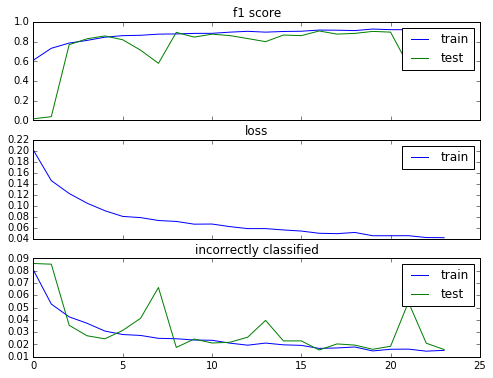

In [9]:
# plot currently running training
results.plot_experiment()